In [2]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import cmocean
import xarray as xr
import xroms
import glob
import os
import datetime
import numpy as np
import dateutil
import dask
import pandas as pd

from scipy.signal import welch
from scipy.fft import fft, fftfreq

In [3]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster(dashboard_address=':8787')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36135,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:42945,Total threads: 8
Dashboard: http://127.0.0.1:41023/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:33761,


In [4]:
data_path = '/southern/rbarkan/data/SWC2km/OUTPUT/W_rivers/HIS/'
save_path = '/meddy/lwang/data/SWC2km_Wrivers_data/'
figure_dir = '/meddy/lwang/figures/model_validation/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [5]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
mask=grd.mask_rho
grd

<xarray.Dataset> Size: 210MB
Dimensions:     (eta_rho: 1296, xi_rho: 1502, eta_v: 1295, xi_u: 1501)
Dimensions without coordinates: eta_rho, xi_rho, eta_v, xi_u
Data variables: (12/21)
    angle       (eta_rho, xi_rho) float64 16MB ...
    cent_lat    float64 8B ...
    f           (eta_rho, xi_rho) float64 16MB ...
    flip_xy     float64 8B ...
    h           (eta_rho, xi_rho) float64 16MB ...
    hraw        (eta_rho, xi_rho) float64 16MB ...
    ...          ...
    spherical   |S1 1B ...
    tapering    float64 8B ...
    tra_lat     float64 8B ...
    tra_lon     float64 8B ...
    wgt         (eta_rho, xi_rho) float64 16MB ...
    river_flux  (eta_rho, xi_rho) float32 8MB ...
Attributes:
    Title:     ROMS grid produced by Easy Grid
    Settings:  nx=1500 ny=1294 size_x=3000 size_y=2500 cent_lat=55 tapering=0...
    Date:      16-Apr-2024
    history:   Thu Nov 21 11:12:03 2024: ncks -x -v river_flux SWC2km_grd.nc ...
    NCO:       netCDF Operators version 4.9.2-alpha05 (Homepage = http://nco....

In [7]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])
lon_mooring, lat_mooring = 116,19.5
lat_min, lat_max = lat_mooring-0.05, lat_mooring+0.05
lon_min, lon_max = lon_mooring-0.05, lon_mooring+0.05
index = np.argwhere( (lat>lat_min) & (lat<lat_max) & (lon>lon_min) & (lon<lon_max))

print('i:', np.min(index[:,1]), np.max(index[:,1]))
print('j:', np.min(index[:,0]), np.max(index[:,0]))

i0, i1 = np.min(index[:,1]), np.max(index[:,1])
j0, j1 = np.min(index[:,0]), np.max(index[:,0])

i: 934 940
j: 932 938


/tmp/ipykernel_2769195/35876263.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)


Text(0, 0.5, 'Depth [m]')

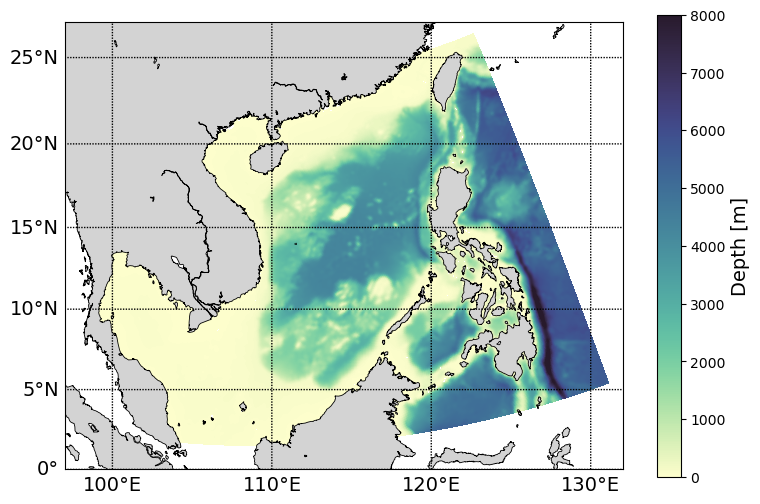

In [19]:
fig, ax = plt.subplots(1,1,figsize=(9.,6.))

m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
depth = grd.h.where(mask > 0)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)

xp_upperleft, yp_upperleft = m(lon[j0,i1],lat[j0,i1])
xp_upperright, yp_upperright = m(lon[j1,i1],lat[j1,i1])
xp_lowerleft, yp_lowerleft = m(lon[j0,i0],lat[j0,i0])
xp_lowerright, yp_lowerright = m(lon[j1,i0],lat[j1,i0])
plt.plot([xp_upperleft,xp_upperright],[yp_upperleft,yp_upperright],'k-',linewidth=0.4)
plt.plot([xp_upperleft,xp_lowerleft],[yp_upperleft,yp_lowerleft],'k-',linewidth=0.4)
plt.plot([xp_lowerleft,xp_lowerright],[yp_lowerleft,yp_lowerright],'k-',linewidth=0.4)
plt.plot([xp_upperright,xp_lowerright],[yp_upperright,yp_lowerright],'k-',linewidth=0.4)

xptext, yptext = m(-21.5,46.5)
plt.text(xptext,yptext, 'PAP site', fontsize=15)

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=14)

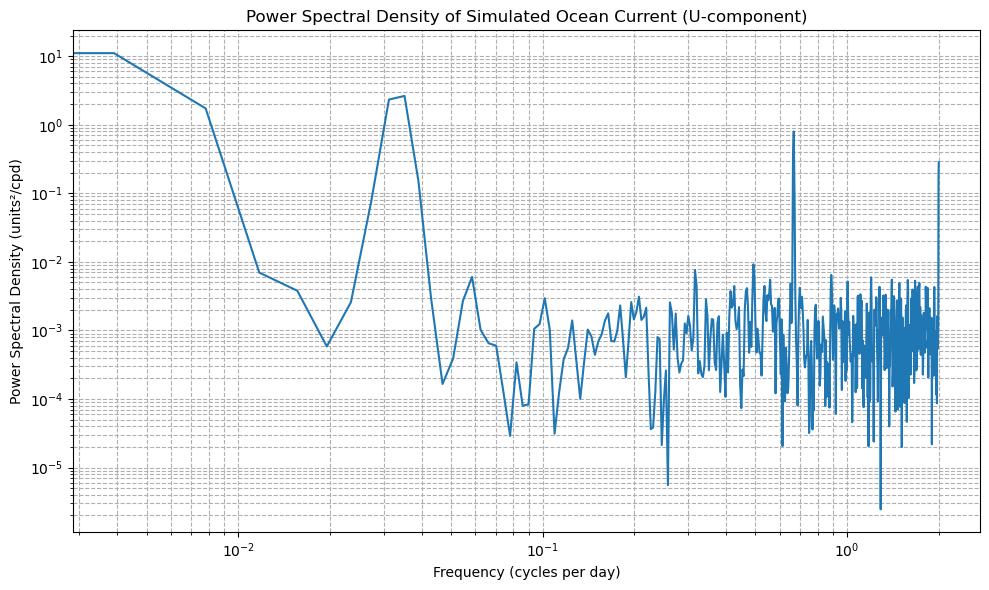

In [5]:
np.random.seed(0)
days = 365
samples_per_day = 4
t = np.linspace(0, days, days * samples_per_day)

# Combine typical oceanic signals
seasonal = 0.5 * np.sin(2 * np.pi * t / 365)      # annual cycle
mesoscale = 0.2 * np.sin(2 * np.pi * t / 30)      # mesoscale eddies (~1 month)
inertial = 0.1 * np.sin(2 * np.pi * t / 1.5)      # inertial oscillations (~1.5 days)
tide = 0.05 * np.sin(2 * np.pi * t / 0.5)         # semi-diurnal tide (~12 hours)
noise = 0.05 * np.random.randn(len(t))           # white noise

# Synthetic ocean current time series
u_current = seasonal + mesoscale + inertial + tide + noise

# ---------------------------
# 2. Compute PSD using Welch's method
# ---------------------------
fs = samples_per_day  # sampling frequency [samples per day]
nperseg = 1024        # segment length for FFT

freqs, psd = welch(u_current, fs=fs, nperseg=nperseg)

# ---------------------------
# 3. Plot the Power Spectral Density
# ---------------------------
plt.figure(figsize=(10, 6))
plt.loglog(freqs, psd)
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Power Spectral Density (units²/cpd)")
plt.title("Power Spectral Density of Simulated Ocean Current (U-component)")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [16]:
ds = xr.open_dataset(data_path + 'SWC2km_his.145367.nc')

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>


In [ ]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])
lat_loc, lon_loc = 18, 115
index = np.argwhere( (lat>lat_min) & (lat<lat_max) & (lon>lon_min) & (lon<lon_max))

In [5]:
ds = xr.open_zarr(save_path + 'surface_u_rechunk.zarr')
ds

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [20]:
u_series = ds['u'].sel(eta_rho=485, xi_rho=661)
u = u_series.values
u = u[~np.isnan(u)]

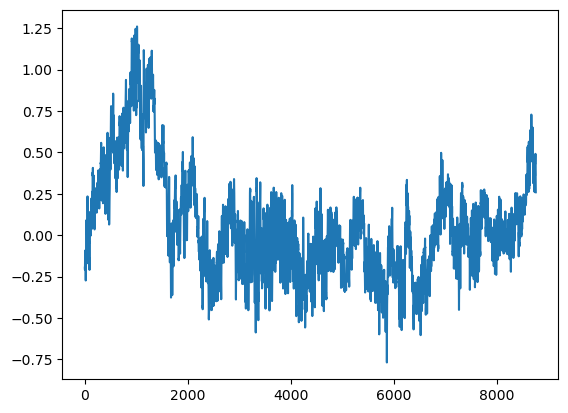

In [21]:
plt.plot(u)

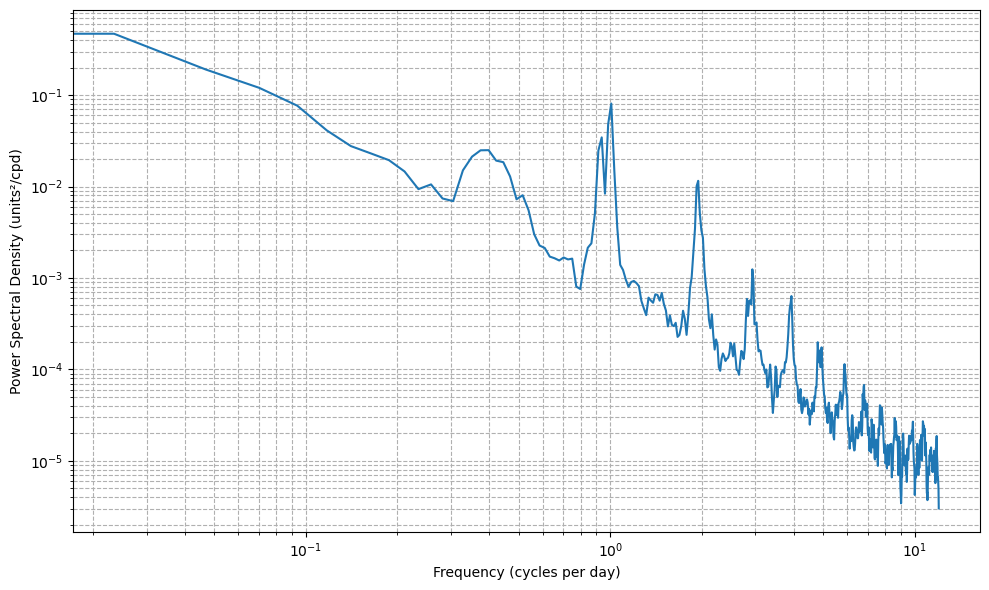

In [27]:
fs = 24  # samples per day
freqs, psd = welch(u, fs=fs, nperseg=1024)

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(freqs, psd)
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Power Spectral Density (units²/cph)")
#plt.title("PSD of Ocean Current at 10°N, 150°E")
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()
plt.show()

In [75]:
lat=grd['lat_rho'][485,661].values
lat

array(11.51595588)

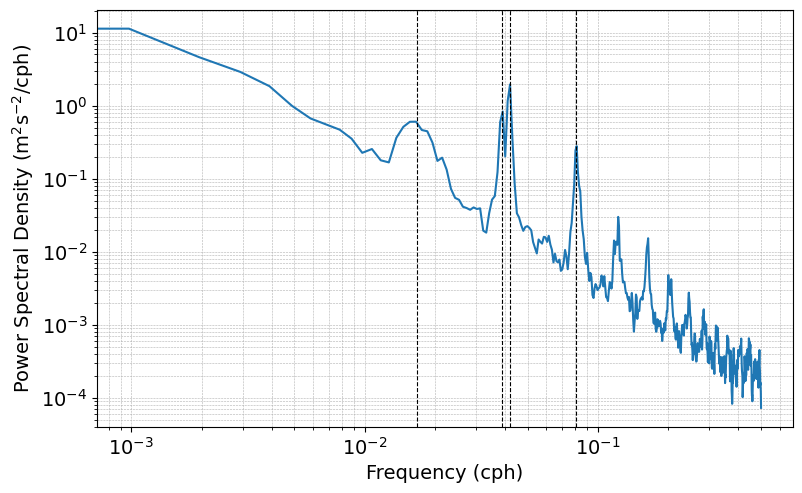

In [85]:
fs = 1  # samples per hour
freqs, psd = welch(u, fs=fs, nperseg=1024)



M2=12.42
K1=23.93
O1=25.82

lat=grd['lat_rho'][485,661].values
omega = 7.2921*1e-5
f=2*omega*math.sin(math.radians(lat))
T=2*np.pi/f/3600


# Plot
fig, ax = plt.subplots(1,1,figsize=(8,5.))
plt.loglog(freqs, psd)
plt.xlabel('Frequency (cph)',fontsize=14)
plt.ylabel('Power Spectral Density (m' + r'$^2$' +'s' + r'$^{-2}$' + '/cph)',fontsize=14)
#plt.title("PSD of Ocean Current at 10°N, 150°E")
plt.grid(True, which="both", linestyle="--",linewidth=0.4)
plt.tight_layout()
plt.axvline(x=1/O1,color='k',linestyle='--',linewidth=0.8)
plt.axvline(x=1/K1,color='k',linestyle='--',linewidth=0.8)
plt.axvline(x=1/M2,color='k',linestyle='--',linewidth=0.8)
plt.axvline(x=1/T,color='k',linestyle='--',linewidth=0.8)
ax.tick_params(labelsize=14)